In [1]:
# Author: University of Washington Center for Human Rights
# Date: 2019-04-29
# License: GPL 3.0 or greater
# Path: ice-air/analyze/note/airport.ipynb

import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import seaborn as sns

This notebook and its outputs are of an exploratory nature only and do not necessarily reflect the final findings of UWCHR as published in the report ["Hidden in Plain Sight: ICE Air and the Machinery of Mass Deportation"](https://jsis.washington.edu/humanrights/2019/04/23/ice-air/).

# Import

First we open a file containing a dictionary of columns and associated data types generated in `../../optimize/`, then we read input file.

In [2]:
with open('../input/dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

df = pd.read_csv('../input/ice-air.csv.gz', **read_csv_opts)

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1732625 entries, 0 to 1732624
Data columns (total 48 columns):
Status                          category
Sex                             category
Convictions                     category
GangMember                      category
ClassLvl                        float32
Age                             float32
MissionDate                     datetime64[ns]
MissionNumber                   uint32
PULOC                           category
DropLoc                         category
StrikeFromList                  float32
ReasonStruck                    category
R-T                             category
Code                            category
CountryOfCitizenship            category
Juvenile                        bool
MissionWeek                     uint8
MissionQuarter                  uint8
MissionYear                     uint16
MissionMonth                    uint8
Criminality                     category
FamilyUnitFlag                  float32


In [3]:
with open('../input/airport_dict.yaml', 'r') as yamlfile:
    airport_dict = yaml.load(yamlfile)

In [4]:
df[df['MissionID'] == 45794]

,Status,Sex,Convictions,GangMember,ClassLvl,Age,MissionDate,MissionNumber,PULOC,DropLoc,...,st2_StateAbbr,aor2_AORID,aor2_AOR,aor2_AORName,air2_Country,air_LatitudeDecimalDegrees,air_LongitudeDecimalDegrees,air2_LatitudeDecimalDegrees,air2_LongitudeDecimalDegrees,NonCriminal
1550828,3,M,Domestic Violence,N,NaN,46.0,2018-01-02,180439,KIWA,KSAN,...,CA,20.0,SND,San Diego,USA,33.307833,-111.655472,32.733000,-117.189000,False
1550829,16,M,Burglary,N,NaN,46.0,2018-01-02,180439,KOAK,KIWA,...,AZ,17.0,PHO,Phoenix,USA,37.721000,-122.221000,33.307833,-111.655472,False
1550830,8C,M,Assault,N,NaN,37.0,2018-01-02,180439,KSAN,KIWA,...,AZ,17.0,PHO,Phoenix,USA,32.733000,-117.189000,33.307833,-111.655472,False
1550831,8G,M,NC,N,NaN,31.0,2018-01-02,180439,KSAN,KIWA,...,AZ,17.0,PHO,Phoenix,USA,32.733000,-117.189000,33.307833,-111.655472,True
1550832,8G,M,NC,N,NaN,24.0,2018-01-02,180439,KSAN,KIWA,...,AZ,17.0,PHO,Phoenix,USA,32.733000,-117.189000,33.307833,-111.655472,True
1550833,8C,M,Murder / Homicide,N,NaN,37.0,2018-01-02,180439,KSAN,KIWA,...,AZ,17.0,PHO,Phoenix,USA,32.733000,-117.189000,33.307833,-111.655472,False
1550834,16,M,Dangerous Drugs,N,NaN,54.0,2018-01-02,180439,KSAN,KIWA,...,AZ,17.0,PHO,Phoenix,USA,32.733000,-117.189000,33.307833,-111.655472,False
1550835,8C,M,Smuggling Aliens,N,NaN,23.0,2018-01-02,180439,KSAN,KIWA,...,AZ,17.0,PHO,Phoenix,USA,32.733000,-117.189000,33.307833,-111.655472,False
1550836,8C,F,NC,N,NaN,26.0,2018-01-02,180439,KSAN,KIWA,...,AZ,17.0,PHO,Phoenix,USA,32.733000,-117.189000,33.307833,-111.655472,True
1550837,8F,M,NC,N,NaN,24.0,2018-01-02,180439,KSAN,KIWA,...,AZ,17.0,PHO,Phoenix,USA,32.733000,-117.189000,33.307833,-111.655472,True


# Specific airport

In [5]:
# Select records for an airport represented in the database using its 4-character ICAO code
airport = 'KEWR'

In [6]:
airport_name = airport_dict[airport]['AirportName']

# Creating DataFrames for pickup and dropoff records.
# If memory usage is too great these can be deleted and assigned again as needed.
pickup = df['PULOC'] == airport
dropoff = df['DropLoc'] == airport
pickup_df = df[pickup].copy()
dropoff_df = df[dropoff].copy()

first_pickup = pickup_df.MissionDate.min()
last_pickup = pickup_df.MissionDate.max()
first_dropoff = dropoff_df.MissionDate.min()
last_dropoff = dropoff_df.MissionDate.max()

pickup_df.set_index('MissionDate', inplace=True)
dropoff_df.set_index('MissionDate', inplace=True)

# DataFrame for all records relating to selected airport.
all_df = pd.concat([pickup_df, dropoff_df]).drop_duplicates()

# DataFrames for all records categorized as removals, transfers.
removal = all_df['R-T'] == 'R'
transfer = all_df['R-T'] == 'T'
removal_df = all_df[removal].copy()
transfer_df = all_df[transfer].copy()

# Names here are used downstream in figure labels.
all_df.name = 'Passengers'
removal_df.name = 'Removals'
transfer_df.name = 'Transfers'
pickup_df.name = 'Departures'
dropoff_df.name = 'Arrivals'

# This grouped table would work for mapping flights from specific airports.
all_missions = all_df.groupby(['MissionDate', 'MissionID', 'PULOC', 'DropLoc'])['AlienMasterID'].nunique()

# Resampled counts of passengers and missions for different timeframes and types of record.
weekly_pickups = pickup_df['AlienMasterID'].resample('W').nunique()
weekly_dropoffs = dropoff_df['AlienMasterID'].resample('W').nunique()
monthly_pickups = pickup_df['AlienMasterID'].resample('M').nunique()
monthly_dropoffs = dropoff_df['AlienMasterID'].resample('M').nunique()
monthly_pickup_missions = pickup_df['MissionID'].resample('M').nunique()
monthly_dropoff_missions = dropoff_df['MissionID'].resample('M').nunique()
annual_pickups = pickup_df['AlienMasterID'].resample('AS-OCT').nunique()
annual_dropoffs = dropoff_df['AlienMasterID'].resample('AS-OCT').nunique()
annual_removals = removal_df['AlienMasterID'].resample('AS-OCT').nunique()
annual_transfers = transfer_df['AlienMasterID'].resample('AS-OCT').nunique()
annual_total = all_df['AlienMasterID'].resample('AS-OCT').nunique()
annual_pickup_missions = pickup_df['MissionID'].resample('AS-OCT').nunique()
annual_dropoff_missions = dropoff_df['MissionID'].resample('AS-OCT').nunique()
annual_total_missions = all_df['MissionID'].resample('AS-OCT').nunique()

# Various descriptive statistics for selected airport
unique_pickups = len(set(pickup_df['AlienMasterID']))
unique_dropoffs = len(set(dropoff_df['AlienMasterID']))
unique_removals = len(set(removal_df['AlienMasterID']))
unique_transfers = len(set(transfer_df['AlienMasterID']))
total_unique = len(set(all_df['AlienMasterID']))
removal_percent = unique_removals / total_unique * 100
transfer_percent = unique_transfers / total_unique * 100
monthly_dropoff_avg = round(monthly_dropoffs.mean(), 2)
monthly_pickup_avg = round(monthly_pickups.mean(), 2)
monthly_dropoff_mission_avg = round(monthly_dropoff_missions.mean(), 2)
monthly_pickup_mission_avg = round(monthly_pickup_missions.mean(), 2)
unique_pickup_missions = len(set(pickup_df['MissionID']))
unique_dropoff_missions = len(set(dropoff_df['MissionID']))

In [7]:
total_unique

46889

In [95]:
unique_removals

7089

In [96]:
unique_transfers

39800

In [8]:
# Top destination airports for removals from selected airport
pickup_df[pickup_df['R-T'] == 'R']['air2_AirportName'].value_counts().head(10)

Brownsville South Padre Island International Airport    3326
Valley International Airport                            3242
Laredo International Airport                             228
Ramon Villeda Morales International Airport              121
El Salvador International Airport                         70
San Antonio International Airport                         63
Alexandria International Airport                          35
Phoenix-Mesa-Gateway Airport                               3
L.F. Wade International International Airport              0
Budapest Liszt Ferenc international Airport                0
Name: air2_AirportName, dtype: int64

In [9]:
# Top destination airports for transfers from selected airport
pickup_df[pickup_df['R-T'] == 'T']['air2_AirportName'].value_counts().head(10)

Alexandria International Airport                        23673
Phoenix-Mesa-Gateway Airport                              123
Harrisburg International Airport                           79
Brownsville South Padre Island International Airport       60
Albuquerque International Sunport Airport                  56
George Bush Intercontinental Houston Airport               39
Fort Worth Meacham International Airport                   36
San Antonio International Airport                          30
Gary Chicago International Airport                         14
El Paso International Airport                              10
Name: air2_AirportName, dtype: int64

In [10]:
missions_df = all_missions.reset_index()
missions_df = missions_df.rename({"AlienMasterID": "Passengers"}, axis=1)

In [11]:
missions_df.to_csv(f'../output/{airport}_missions.csv', index=False)

# Annual trends (by fiscal year)

In [12]:
fy_index = pd.date_range(start='2010-10-01', end='2018-01-01', freq='AS-OCT')

In [13]:
annual_pickups.rename('Total pickups', inplace=True)
annual_dropoffs.rename('Total dropoffs', inplace=True)
annual_removals.rename('Total removals', inplace=True)
annual_transfers.rename('Total transfers', inplace=True)
annual_total.rename('Total passengers', inplace=True)
annual_pickup_missions.rename('Total pickup missions', inplace=True)
annual_dropoff_missions.rename('Total dropoff missions', inplace=True)
annual_total_missions.rename('Total missions', inplace=True)

MissionDate
2010-10-01     1
2011-10-01    81
2012-10-01    72
2013-10-01    98
2014-10-01    81
2015-10-01    76
2016-10-01    94
2017-10-01    86
2018-10-01    13
Freq: AS-OCT, Name: Total missions, dtype: int64

In [14]:
annual_summary = pd.DataFrame({'Annual Pickups': annual_pickups,
              'Annual Pickup Missions': annual_pickup_missions,
              'Annual Dropoffs': annual_dropoffs,
              'Annual Dropoff Missions': annual_dropoff_missions,
              'Annual Removals': annual_removals,
              'Annual Transfers': annual_transfers,
              'Annual Total Passengers': annual_total,
              'Annual Total Missions': annual_total_missions}, index=fy_index)

In [15]:
annual_summary.index = annual_summary.index.year+1 
annual_summary.index.name = 'Fiscal Year'

In [16]:
annual_summary

,Annual Pickups,Annual Pickup Missions,Annual Dropoffs,Annual Dropoff Missions,Annual Removals,Annual Transfers,Annual Total Passengers,Annual Total Missions
Fiscal Year,,,,,,,,
2011,55,1,NaN,NaN,55,NaN,55,1
2012,6996,79,910.0,59.0,2192,5714.0,7906,81
2013,5941,67,2285.0,58.0,1247,6979.0,8226,72
2014,4880,75,5129.0,90.0,1288,8721.0,10009,98
2015,2650,74,1927.0,73.0,482,4095.0,4577,81
2016,2289,68,2287.0,75.0,187,4389.0,4576,76
2017,4238,85,1592.0,72.0,542,5288.0,5830,94
2018,3523,82,1257.0,70.0,954,3826.0,4780,86


In [17]:
flat_summary = annual_summary.unstack().to_frame().T 

In [18]:
flat_summary.index = [airport]

In [19]:
flat_summary.columns = flat_summary.columns.tolist()

In [20]:
flat_summary

,"(Annual Pickups, 2011)","(Annual Pickups, 2012)","(Annual Pickups, 2013)","(Annual Pickups, 2014)","(Annual Pickups, 2015)","(Annual Pickups, 2016)","(Annual Pickups, 2017)","(Annual Pickups, 2018)","(Annual Pickup Missions, 2011)","(Annual Pickup Missions, 2012)",...,"(Annual Total Passengers, 2017)","(Annual Total Passengers, 2018)","(Annual Total Missions, 2011)","(Annual Total Missions, 2012)","(Annual Total Missions, 2013)","(Annual Total Missions, 2014)","(Annual Total Missions, 2015)","(Annual Total Missions, 2016)","(Annual Total Missions, 2017)","(Annual Total Missions, 2018)"
KEWR,55.0,6996.0,5941.0,4880.0,2650.0,2289.0,4238.0,3523.0,1.0,79.0,...,5830.0,4780.0,1.0,81.0,72.0,98.0,81.0,76.0,94.0,86.0


In [21]:
annual_summary.to_csv(f'../output/{airport}_annual_summary.csv')

In [22]:
def bar_chart(data, airport=str, airport_name=str, filename=str, title=str):
    fig, ax = plt.subplots()

    data.plot(kind='bar',
              ax=ax,
              stacked=True,
              title=f'{airport_name}',
              rot=0,
              grid=True,
              figsize=(8,6),
              fontsize=14)
    ax.set_axisbelow(True)
    ax.set_facecolor('#EEEEEE')
    ax.grid(color='#FFFFFF')
    ax.set_ylabel('Number of Passengers', fontsize=16)
    ax.set_ylim(0)
    ax.set_xlabel('Fiscal Year', fontsize=16)
    ax.set_title(f'{title}', fontsize=18)
    ax.tick_params(labelsize=14)
    ax.legend(fontsize=14)
    txt='(Source: UWCHR, ICE Air ARTS database)'
    plt.figtext(0.7, .02, txt, wrap=True, horizontalalignment='center', fontsize=12)
    
    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/{airport}_{filename}.png')
    plt.show()
    plt.close()

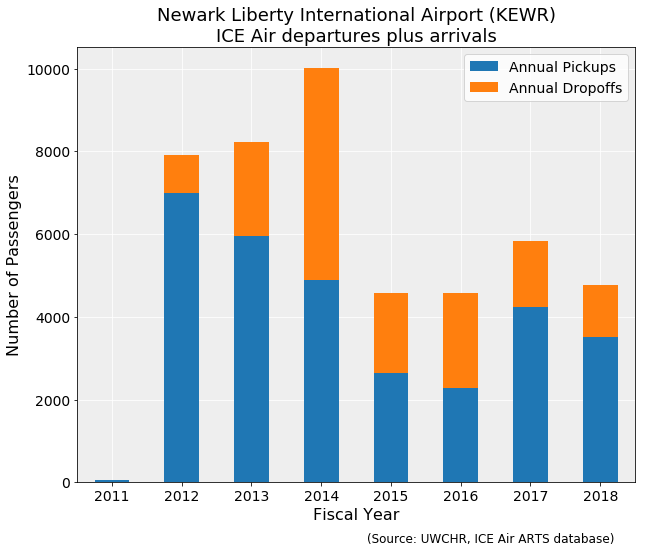

In [23]:
data = annual_summary[['Annual Pickups', 'Annual Dropoffs']]
title = f'{airport_name} ({airport})\nICE Air departures plus arrivals'
bar_chart(data, airport, airport_name, 'pickup-dropoff', title)
plt.show()

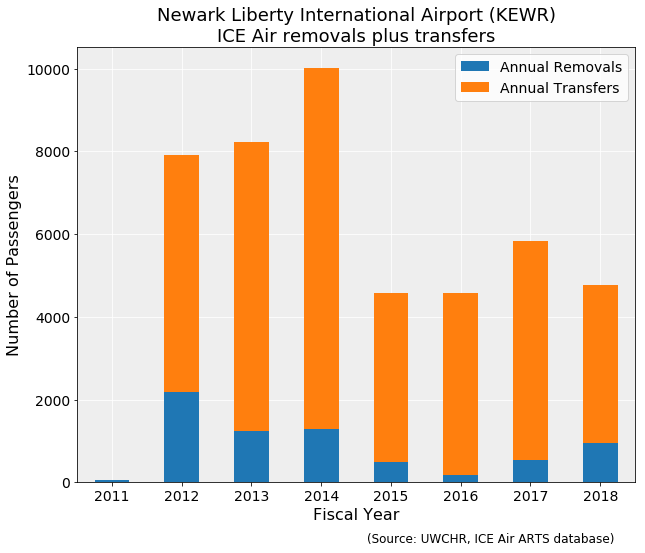

In [24]:
data = annual_summary[['Annual Removals', 'Annual Transfers']]
title = f'{airport_name} ({airport})\nICE Air removals plus transfers'
bar_chart(data, airport, airport_name, 'removal-transfer', title)
plt.show()

In [25]:
annual_summary[['Annual Pickups', 'Annual Dropoffs']].to_csv(f'../output/{airport}-AnnualDeparturesArrivals.csv')

In [26]:
all_df.to_csv(f'../output/{airport}-allpassengers.csv')

# Annual pickup rate, by criminal conviction status

WARNING: Criminal conviction data is not consistently recorded by ICE, especially in FY 11.

In [27]:
annual_non_criminal = pickup_df[['NonCriminal']].resample('AS-OCT').sum()

In [28]:
annual_non_criminal['total'] = annual_pickups
annual_non_criminal['percent'] = annual_non_criminal['NonCriminal']/annual_pickups*100

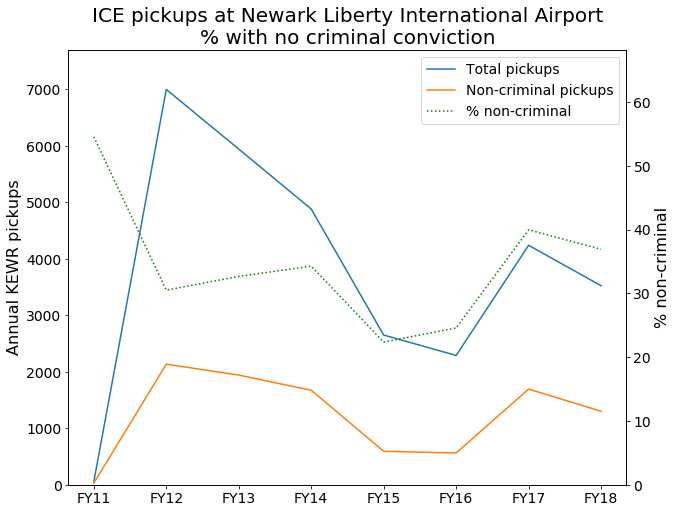

In [29]:
annual_data = annual_non_criminal['2010':'2017']
annual_data.index = [f'FY{str(x)[2:4]}' for x in range(2011,2019)]

# plt.style.use([{'legend.frameon': True}])
plt.rc("font", family="Sans-Serif")

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

lns1 = ax1.plot(annual_data['total'], label='Total pickups')
lns2 = ax1.plot(annual_data['NonCriminal'], label='Non-criminal pickups')
ax1_max = annual_data['total'].max()
ax1.set_ylim(0, (ax1_max * 1.1))
ax1.set_ylabel(f'Annual {airport} pickups', fontsize=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax2.grid(None)

lns3 = ax2.plot(annual_data['percent'], label='% non-criminal', linestyle=':', color='green')
ax2_max = annual_data['percent'].max()
ax2.set_ylim(0, (ax2_max * 1.25))
ax2.set_ylabel('% non-criminal', fontsize=16)
ax2.tick_params(axis='y', labelsize=14)
ax2.grid(None)
# ax2.set_xticklabels([f'FY{str(x)[2:4]}' for x in range(2011,2019)])

lns = [lns1[0], lns2[0], lns3[0]]
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0, fontsize=14)

ax1.set_title(f'ICE pickups at {airport_name}\n% with no criminal conviction', fontsize=20)

fig.set_size_inches(10, 8)

plt.show()
fig.savefig(f'../output/{airport}_NoCrim.png', dpi=100)

# Monthly averages (by FY)

Calculating average rates of pickups, dropoffs, and flights for each calendar year in the dataset.

In [30]:
monthly_means = pd.DataFrame()
for year in range(2011, 2019):
    mean_pickups = monthly_pickups[f'{year}'].mean()
    mean_pickup_missions = monthly_pickup_missions[f'{year}'].mean()
    mean_dropoffs = monthly_dropoffs[f'{year}'].mean()
    mean_dropoff_missions = monthly_dropoff_missions[f'{year}'].mean()
    monthly_means = monthly_means.append({'calendar_year':year,
                                          'monthly_mean_pickups':mean_pickups,
                                          'monthly_mean_dropoffs':mean_dropoffs,
                                          'monthly_mean_pickup_missions':mean_pickup_missions,
                                          'monthly_mean_dropoff_missions':mean_dropoff_missions,
                                         }, ignore_index=True)
monthly_means['calendar_year'] = monthly_means['calendar_year'].astype(int)
monthly_means = monthly_means.set_index('calendar_year')

In [31]:
monthly_means.round(2)

,monthly_mean_dropoff_missions,monthly_mean_dropoffs,monthly_mean_pickup_missions,monthly_mean_pickups
calendar_year,,,,
2011,4.00,34.67,4.00,328.25
2012,5.00,89.83,6.83,605.00
2013,5.50,248.08,5.42,475.25
2014,7.58,406.42,6.75,382.75
2015,5.83,159.25,5.92,189.00
2016,6.67,206.50,5.58,212.83
2017,5.50,81.25,7.42,353.25
2018,5.42,105.92,5.92,274.00


In [32]:
monthly_means.to_csv(f'../output/{airport}_monthly_means.csv')

# Top nationalities

In [33]:
pickup_df.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(10)

MEXICO                7762
GUATEMALA             5437
EL SALVADOR           4347
HONDURAS              4278
DOMINICAN REPUBLIC    3393
ECUADOR               1925
JAMAICA                958
HAITI                  796
COLOMBIA               783
NICARAGUA              182
Name: CountryOfCitizenship, dtype: int64

In [34]:
dropoff_df.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(5)

EL SALVADOR    4103
HONDURAS       2697
GUATEMALA      2544
ECUADOR         525
MEXICO          522
Name: CountryOfCitizenship, dtype: int64

In [35]:
all_df.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(5)

EL SALVADOR           8450
MEXICO                8284
GUATEMALA             7981
HONDURAS              6975
DOMINICAN REPUBLIC    3557
Name: CountryOfCitizenship, dtype: int64

In [36]:
nat_percent = (df.groupby(['CountryOfCitizenship'])['AlienMasterID'].nunique() / len(df)).sort_values(ascending=False)

In [37]:
airport_nat_percent = (all_df.groupby(['CountryOfCitizenship'])['AlienMasterID'].nunique() / len(all_df)).sort_values(ascending=False)

In [38]:
pd.DataFrame({'Nationality as percent of dataset': nat_percent,
              f'Nationality as percent of {airport}': airport_nat_percent}).to_csv(f'../output/{airport}_nationality_percent_comparison.csv')

In [39]:
removal_nationalities = removal_df.groupby([pd.Grouper(freq='AS-OCT'), 'CountryOfCitizenship'])['AlienMasterID'].nunique().unstack()
removal_nationalities.to_csv(f'../output/{airport}_removal_nationalities.csv')

# Chart of top nationalities per year

This chart shows the top five `CountryOfCitizenship` values for each fiscal year. It can be misleading because values are summed in "ALL OTHERS" for years in which a particular nationalitiy is not in the top 5, but it makes clear things like which years certain groups come into or leave the top 5.

Charts can be generated for pickups, dropoffs, removals, transfers, or all records.

In [40]:
# Strangely, copying a DataFrame doesn't copy DataFrame.name
# There's probably a better way to link dataframes to downstream chart labels, though
df_to_analyze = pickup_df.copy()
df_to_analyze.name = pickup_df.name

In [41]:
g = df_to_analyze.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'CountryOfCitizenship'])['AlienMasterID', 'MissionID'].nunique()
country_of_citizenship_by_year = g.reset_index()
country_of_citizenship_by_year.rename({'MissionDate': 'FY'}, axis='columns', inplace=True)
country_of_citizenship_by_year.set_index('FY', inplace=True)
country_of_citizenship_by_year.sort_values(by='AlienMasterID', ascending=False, inplace=True)

# country_of_citizenship_by_year.to_csv(f'../output/{airport}_country_of_citizenship_by_year.csv', index=True)

In [42]:
# Limiting to fiscal years with full data (FY2011-FY2018).
country_of_citizenship_by_year = country_of_citizenship_by_year['2010':'2017']

In [43]:
all_passenger_nationality_by_year = country_of_citizenship_by_year.groupby([pd.Grouper(freq='AS-OCT'),'CountryOfCitizenship'])[['AlienMasterID']].sum().dropna(how='all',axis=0).unstack()
all_passenger_nationality_by_year.to_csv(f'../output/{airport}_all_passenger_nationality_by_year.csv')

In [44]:
all_passenger_nationality_by_year.loc['2016':'2017'].T.dropna(how='all').to_csv(f'../output/{airport}_pickups_by_nationality.csv')

In [45]:
top_5_df = pd.DataFrame()

for year in country_of_citizenship_by_year.index.unique():
    temp = country_of_citizenship_by_year.loc[f'{year}'][['CountryOfCitizenship', 'AlienMasterID']]
    temp_top_5 = temp[0:5]
    if len(temp) > 5:
        all_other_count = sum(temp['AlienMasterID'][5:])
    else:
        all_other_count = 0
    other_df = pd.DataFrame([['ALL OTHERS', all_other_count]], columns=['CountryOfCitizenship', 'AlienMasterID'], index=[year])
    temp_top_5 = temp_top_5.append(other_df)
    top_5_df = top_5_df.append(temp_top_5)
    
top_5_df.sort_index(inplace=True)
top_5_df.index = [f'FY{str(x)[2:4]}' for x in top_5_df.index.year + 1]

top_5_data = pd.pivot_table(data=top_5_df,
                       index=top_5_df.index,
                       columns='CountryOfCitizenship',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)

top_5_data = top_5_data.reindex(top_5_data.sum().sort_values(ascending=False).index, axis=1)
cols = list(top_5_data.columns)
cols.remove('ALL OTHERS')
cols.append('ALL OTHERS')
top_5_data = top_5_data[cols]

top_5_data.columns = top_5_data.columns.str.title()
top_5_data.columns.name = 'Country of Citizenship'

In [46]:
def country_of_citizenship_trend(data, title=str, filename=str, xlabel=str, ylabel=str):
    
    fig, ax = plt.subplots()
    
    data.plot(kind='bar', stacked=True, legend=True, ax=ax).legend(bbox_to_anchor=(1,1))

    ax.set_axisbelow(True)
    ax.set_facecolor('#EEEEEE')
    ax.grid(color='#FFFFFF')
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_title(title, fontsize=18)
    ax.tick_params(labelsize=14)
    plt.xticks(rotation=0)
    txt='(Source: UWCHR, ICE Air ARTS database)'
    txt=plt.figtext(0.7, -0.00, txt, wrap=True, horizontalalignment='center', fontsize=12)
    lgd=plt.legend(fontsize=12)

    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/{filename}.png', dpi=100, bbox_extra_artists=(lgd,txt), bbox_inches='tight')
    return fig, ax

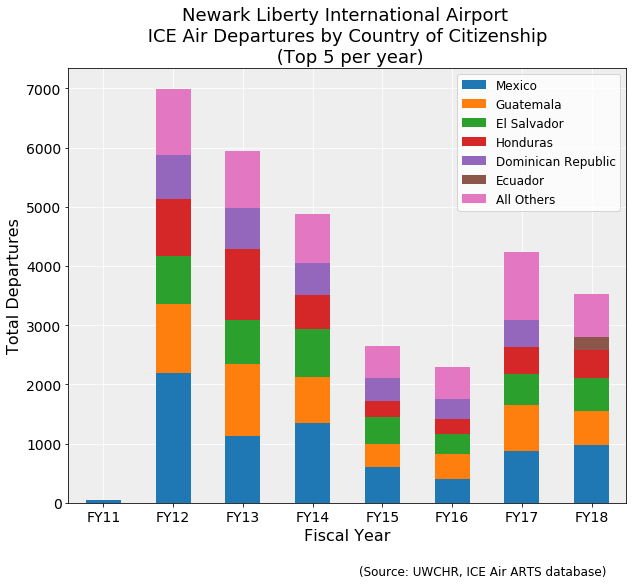

In [47]:
country_of_citizenship_trend(top_5_data,
                             title=f'{airport_name} \n ICE Air {df_to_analyze.name} by Country of Citizenship \n (Top 5 per year)',
                             filename=f'{airport}_top5_nationalities',
                             ylabel=f'Total {df_to_analyze.name}',
                             xlabel='Fiscal Year');

In [48]:
g = pickup_df.groupby(['PULOC', pd.Grouper(freq='AS-OCT', sort=True), 'air2_AirportName'])['AlienMasterID','MissionID'].nunique()
drop_locs_by_year = g.reset_index()
drop_locs_by_year.rename({'MissionDate': 'FY'}, axis='columns', inplace=True)

# drop_locs_by_year.to_csv(f'../output/{airport}_drop_locs_by_year.csv', index=True)

# Alternate plot of top nationalities

Since selecting top 5 for each year is a bit counterintuitive, we can instead select here an aribtrary number of nationalities to display for all years, while summing others. This can be based on most common values or could be some other arbitrary list. (See also implementation in `global.ipynb` for plotting all values that break top 5 for any year.)

In [49]:
annual = df_to_analyze.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'CountryOfCitizenship'])['AlienMasterID'].nunique()

In [50]:
# There is probably a better way to do this
annual = annual.reset_index()
annual.set_index('MissionDate', inplace=True)
annual = annual['2010':'2017']

In [51]:
# Select arbitrary number of top values to display here
number_of_top_values = 5
annual_sum = annual.groupby(['CountryOfCitizenship'])['AlienMasterID'].sum()
top = list(annual_sum.sort_values(ascending=False).head(number_of_top_values).index)

top_df = pd.DataFrame()
top_df = top_df.append(annual[annual['CountryOfCitizenship'].isin(top)])
top_df.index = top_df.index.year

for year in annual.index.year.unique():
    temp = annual[f'{year}']
    temp2 = temp[~temp['CountryOfCitizenship'].isin(top)]
    all_other_count = temp2['AlienMasterID'].sum()
    other_df = pd.DataFrame([['ALL OTHERS', all_other_count]],
                            columns=['CountryOfCitizenship',
                                     'AlienMasterID'],
                            index=[year])
    top_df = top_df.append(other_df)

top_df.sort_index(inplace=True)
top_df.index = [f'FY{str(x)[2:4]}' for x in top_df.index + 1]

top_df['CountryOfCitizenship'] = top_df['CountryOfCitizenship'].astype('category')

top_data = pd.pivot_table(data=top_df,
                       index=top_df.index,
                       columns='CountryOfCitizenship',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)
top_data = top_data.reindex(top_data.sum().sort_values(ascending=False).index, axis=1)
cols = list(top_data.columns)
cols.remove('ALL OTHERS')
cols.append('ALL OTHERS')
top_data = top_data[cols]
top_data.columns = top_data.columns.astype(str)
top_data.columns = top_data.columns.str.title()

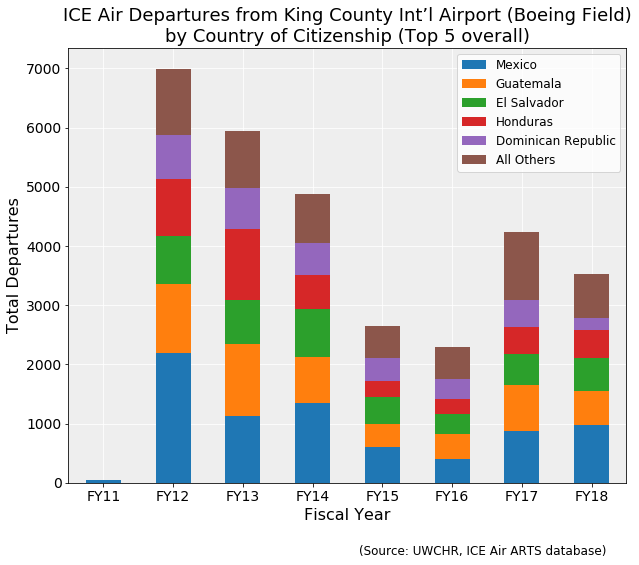

In [52]:
country_of_citizenship_trend(top_data,
                             title=f'ICE Air Departures from King County Int’l Airport (Boeing Field)\nby Country of Citizenship (Top 5 overall)',
                             filename=f'{airport}_pickup_nationalities',
                             ylabel=f'Total {df_to_analyze.name}',
                             xlabel='Fiscal Year');

# Not top nationalities

In [53]:
number_of_top_values = 5
annual_sum = annual.groupby(['CountryOfCitizenship'])['AlienMasterID'].sum()
top = list(annual_sum.sort_values(ascending=False).head(number_of_top_values).index)

not_top_df = pd.DataFrame()
not_top_df = not_top_df.append(annual[~annual['CountryOfCitizenship'].isin(top)])
not_top_df.index = not_top_df.index.year

In [54]:
not_top_data = pd.pivot_table(data=not_top_df,
                       index=not_top_df.index,
                       columns='CountryOfCitizenship',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)
not_top_data = not_top_data.reindex(not_top_data.sum().sort_values(ascending=False).index, axis=1)
# cols = list(not_top_data.columns)
# cols.remove('ALL OTHERS')
# cols.append('ALL OTHERS')
# not_top_data = not_top_data[cols]
# not_top_data.columns = not_top_data.columns.astype(str)
# not_top_data.columns = not_top_data.columns.str.title()

In [55]:
not_top_data.sum().head(15)

CountryOfCitizenship
ECUADOR              1885
JAMAICA               941
HAITI                 788
COLOMBIA              777
NICARAGUA             181
INDIA                  96
GHANA                  88
CHINA                  81
BANGLADESH             79
NIGERIA                58
PAKISTAN               53
CANADA                 50
LIBERIA                42
TRINIDAD & TOBAGO      40
GUYANA                 38
dtype: int64

In [56]:
all_others = not_top_data.sum()[not_top_data.sum() < 50].index
greater_than_x = not_top_data.sum()[not_top_data.sum() > 50].index
to_plot = not_top_data[greater_than_x].copy()
to_plot.columns = to_plot.columns.astype(str)
to_plot['ALL OTHERS'] = not_top_data[all_others].sum(axis=1)

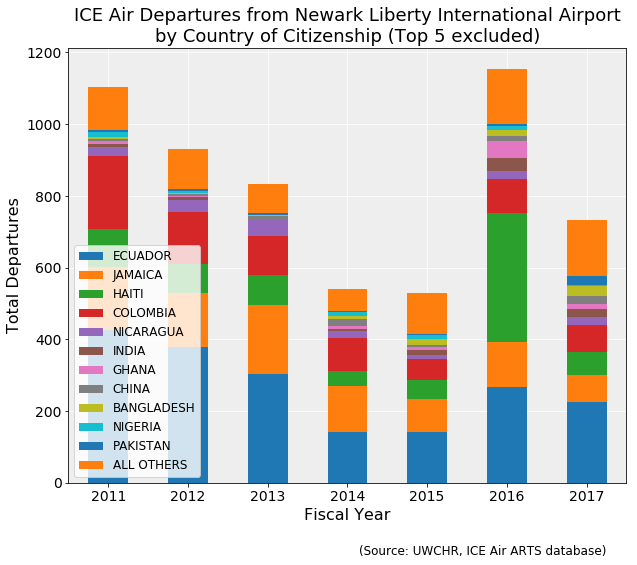

In [57]:
country_of_citizenship_trend(to_plot,
                             title=f'ICE Air Departures from {airport_name}\nby Country of Citizenship (Top 5 excluded)',
                             filename=f'{airport}_pickup_nationalities_top_5_excluded',
                             ylabel=f'Total {df_to_analyze.name}',
                             xlabel='Fiscal Year');

# Juveniles (by fiscal year)

Table of just juveniles for pickups, dropoffs. Currently will fail if no juveniles.

In [58]:
assert sum(all_df['Juvenile']) > 0, f"No juveniles in dataset for {airport}"

In [59]:
g = pickup_df.groupby(['PULOC', pd.Grouper(freq='AS-OCT', sort=True), 'Juvenile'])['AlienMasterID'].nunique()
juvenile_pickups = g.unstack()
juvenile_pickups['percent'] = juvenile_pickups[True] / juvenile_pickups[False] * 100
juvenile_pickups

Juvenile            False  True   percent
PULOC MissionDate                        
KEWR  2010-10-01     55.0   NaN       NaN
      2011-10-01   6993.0   3.0  0.042900
      2012-10-01   5940.0   1.0  0.016835
      2013-10-01   4880.0   NaN       NaN
      2014-10-01   2650.0   NaN       NaN
      2015-10-01   2289.0   NaN       NaN
      2016-10-01   4238.0   NaN       NaN
      2017-10-01   3523.0   NaN       NaN
      2018-10-01    646.0   NaN       NaN

In [60]:
g = dropoff_df.groupby(['DropLoc', pd.Grouper(freq='AS-OCT', sort=True), 'Juvenile'])['AlienMasterID'].nunique()
juvenile_pickups = g.unstack()

In [61]:
juvenile_pickups

Juvenile              False   True 
DropLoc MissionDate                
KEWR    2011-10-01    908.0     2.0
        2012-10-01   2274.0    11.0
        2013-10-01   3398.0  1731.0
        2014-10-01   1334.0   593.0
        2015-10-01   2287.0     NaN
        2016-10-01   1592.0     NaN
        2017-10-01   1257.0     NaN
        2018-10-01    284.0     NaN

In [62]:
juvenile_pickups['percent'] = juvenile_pickups[True] / juvenile_pickups[False] * 100
juvenile_pickups

Juvenile              False    True    percent
DropLoc MissionDate                           
KEWR    2011-10-01    908.0     2.0   0.220264
        2012-10-01   2274.0    11.0   0.483729
        2013-10-01   3398.0  1731.0  50.941730
        2014-10-01   1334.0   593.0  44.452774
        2015-10-01   2287.0     NaN        NaN
        2016-10-01   1592.0     NaN        NaN
        2017-10-01   1257.0     NaN        NaN
        2018-10-01    284.0     NaN        NaN

In [63]:
g = all_df.groupby(['R-T', pd.Grouper(freq='AS-OCT', sort=True), 'Juvenile'])['AlienMasterID'].nunique()

In [64]:
juvenile_removal_transfer = g.unstack()
juvenile_removal_transfer

Juvenile          False   True 
R-T MissionDate                
R   2010-10-01     55.0     NaN
    2011-10-01   2192.0     NaN
    2012-10-01   1247.0     NaN
    2013-10-01   1288.0     NaN
    2014-10-01    482.0     NaN
    2015-10-01    187.0     NaN
    2016-10-01    542.0     NaN
    2017-10-01    954.0     NaN
    2018-10-01    142.0     NaN
T   2011-10-01   5709.0     5.0
    2012-10-01   6967.0    12.0
    2013-10-01   6990.0  1731.0
    2014-10-01   3502.0   593.0
    2015-10-01   4389.0     NaN
    2016-10-01   5288.0     NaN
    2017-10-01   3826.0     NaN
    2018-10-01    788.0     NaN

# Detainee status

In [65]:
status_count = removal_df.drop_duplicates(subset='AlienMasterID')['Status'].str.upper().value_counts(dropna=False)

In [66]:
status = pd.read_csv('../../../share/resources/status.csv')

valid_status_codes = list(status['Code'])

status_dict = dict(zip(status['Code'], status['Status']))

pending = ['2A', '2B', '8A', '8B', '8D']
benefit = ['5C', '5D']
expedited_admin_rein = ['8F', '8G', '8H', '8I', '11', '16']
problematic = pending + benefit + expedited_admin_rein

In [67]:
problematic_count = 0
valid = removal_df['Status'].str.upper().isin(valid_status_codes)
valid_count = sum(valid)
invalid = ~removal_df['Status'].str.upper().isin(valid_status_codes)
invalid_count = sum(invalid)

print(f'{airport} - {airport_name}')
print()
print(f'ICE status codes for passengers on direct removal flights.')
print(f'(Statuses which may raise due process concerns starred)')
print()
print(f'{valid_count} valid values.')
print(f'{invalid_count} invalid values.')
print()
for c in valid_status_codes:
    
    try:
        count = status_count[c]
    except KeyError:
        count = 0
    
    if c in problematic:
        problematic_count = problematic_count + count
        print(f'[{c}]: *{count}* ({status_dict[c]})')
    else:
        print(f'[{c}]: {count} ({status_dict[c]})')
print()
print(f'{problematic_count} problematic cases.')

KEWR - Newark Liberty International Airport

ICE status codes for passengers on direct removal flights.
(Statuses which may raise due process concerns starred)

3010 valid values.
4079 invalid values.

[1A]: 0 (Voluntary Departure – Un-Expired and Un-Extended Voluntary Departure.)
[1B]: 0 (Voluntary Departure - Extended Departure Period)
[1C]: 0 (Exipred Voluntary Departure Period - Referred to Investigation)
[2A]: *2* (Deportable – Under Adjudication by IJ)
[2B]: *1* (Deportable – Under Adjudication by BIA)
[3]: 90 (Deportable – Administratively Final Order)
[5A]: 0 (Referred for Investigation - No Show for Hearing - No Final O...)
[5B]: 8 (Removable – ICE Fugitive)
[5C]: *0* (Relief Granted – Withholding of Deportation/Removal)
[5D]: *0* (Final Order of Deportation/Removal – Deferred Action Granted.)
[5E]: 0 (Relief Granted – Extended Voluntary Departure)
[5F]: 0 (Unable to Obtain Travel Document)
[8A]: *14* (Excludable/Inadmissible – Hearing Not Commenced)
[8B]: *61* (Excludable/Ina

In [68]:
sum(removal_df['Status'].isin(expedited_admin_rein))

1394

In [69]:
sum(removal_df['Status'].isin(pending))

83

In [70]:
sum(removal_df['Status'].isin(benefit))

0

In [71]:
status_fy = removal_df.drop_duplicates(subset='AlienMasterID').resample('AS-OCT')['Status'].value_counts().unstack()
status_fy_valid = status_fy[status_fy.columns[status_fy.columns.isin(valid_status_codes)]]

total = removal_df.drop_duplicates(subset='AlienMasterID').resample('AS-OCT')['AlienMasterID'].nunique()

status_fy_valid.T.to_csv(f'../output/{airport}_valid_status_by_year.csv')

all_others = status_fy[status_fy.columns[~status_fy.columns.isin(valid_status_codes)]].sum(axis=1)
all_others.name = 'all_others'

status_table = pd.concat([status_fy_valid, all_others], axis=1).T

status_table.to_csv(f'../output/{airport}_removal_status_by_year.csv')
(status_table/total).to_csv(f'../output/{airport}_removal_status_by_year_percent.csv')

In [72]:
total

MissionDate
2010-10-01      55
2011-10-01    2192
2012-10-01    1247
2013-10-01    1288
2014-10-01     482
2015-10-01     187
2016-10-01     542
2017-10-01     954
2018-10-01     142
Freq: AS-OCT, Name: AlienMasterID, dtype: int64

In [73]:
transfer_status = transfer_df['Status'].value_counts()

In [74]:
transfer_status[transfer_status >= 100]

REMOVAL           8837
8G                7108
8C                4609
16                3632
8F                3560
3                 2808
NTA               2640
11                1207
RM                1113
TRANSFER - F/O     709
STAGER             698
NO STATUS          473
8A                 431
8E                 347
TRANSFER           282
8B                 276
STAGERS            114
2A                 109
10                 108
Name: Status, dtype: int64

In [75]:
pickup_transfer_status = pickup_df[pickup_df['R-T'] == 'T']['Status'].value_counts()

In [76]:
pickup_transfer_status[pickup_transfer_status > 100]

REMOVAL           8720
8C                4155
16                2349
3                 1988
8G                1120
11                1101
RM                 772
8F                 722
STAGER             697
TRANSFER - F/O     672
8E                 322
TRANSFER           234
NO STATUS          229
8B                 211
STAGERS            114
Name: Status, dtype: int64

In [77]:
dropoff_status = dropoff_df['Status'].value_counts()
dropoff_status[dropoff_status > 1]

8G                5988
8F                2838
NTA               2637
16                1283
3                  820
8C                 454
8A                 359
RM                 341
NO STATUS          244
REMOVAL            118
11                 106
10                  84
8B                  65
TRANSFER            48
TRANSFER - F/O      37
2A                  34
REINST              33
8E                  25
8H                  24
WA/NTA              16
2B                  13
1/15/1900           12
8I                  12
NTA-TRFD             9
1A                   9
14                   9
5B                   8
XFR                  7
8D                   5
5F                   3
GUATE                3
REINST-FEAR          2
T                    2
12                   2
HONDU                2
5D                   2
9                    2
Name: Status, dtype: int64

## Finding most common day of week

In [78]:
all_df['MissionWeekday'] = all_df.index.weekday

In [79]:
index = range(0,7)

In [80]:
weekdays_2018 = all_df.loc['2018'].groupby(['MissionWeekday'])['MissionID'].nunique()

In [81]:
weekdays_2018 = weekdays_2018.reset_index()

In [82]:
weekdays_2018 = weekdays_2018.set_index('MissionWeekday')

In [83]:
weekdays_2018 = weekdays_2018.reindex(index=index)

In [84]:
weekdays_2018 = weekdays_2018.rename({'MissionID': 'Flights'}, axis=1)

In [85]:
weekdays_2018 = weekdays_2018.T
weekdays_2018.columns = ['M', 'Tu', 'W', 'Th', 'F', 'Sa', 'Su']

In [86]:
weekdays_2018.fillna(0, inplace=True)

In [87]:
weekdays_2018

,M,Tu,W,Th,F,Sa,Su
Flights,27.0,22.0,20.0,3.0,4.0,0.0,0.0


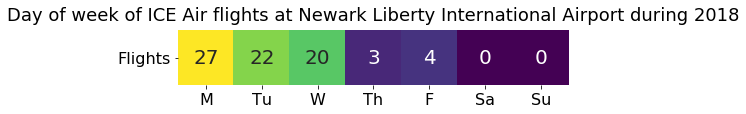

In [88]:
fig, ax = plt.subplots()
fig.set_size_inches(7,1)
ax = sns.heatmap(weekdays_2018, annot=True, annot_kws={"size": 20}, fmt='.0f', cmap=plt.cm.viridis, cbar=False)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16, rotation=0)
# ax.set_ylabel('Year', fontsize=14)
# ax.set_xlabel('Weekday', fontsize=14)
ax.set_title(f'Day of week of ICE Air flights at {airport_name} during 2018', fontsize=18, pad=10);
fig.savefig(f'../output/{airport}-weekdays.png', dpi=100,  bbox_inches='tight')

# Airport report

For a each airport ICAO code represented in the ICE Air data, output a uniform set of variables, tables, and figures.

In [89]:
# airport_dict['KBFI']['AirportName']

In [90]:
# airport_dict['KBFI']

In [91]:
# def airport_report(airport_icao, print_report=False, figure=False):
#     airport = airport_icao
#     if airport.upper() in airport_dict.keys():
#         pass
#     else:
#         print(f'{airport} not represented in dataset')
#     airport_name = airport_dict[airport]['AirportName']
#     pickup = df['PULOC'] == airport
#     dropoff = df['DropLoc'] == airport

#     pickup_df = df[pickup]
#     dropoff_df = df[dropoff]

#     first_pickup = pickup_df.MissionDate.min()
#     last_pickup = pickup_df.MissionDate.max()
#     first_dropoff = dropoff_df.MissionDate.min()
#     last_dropoff = dropoff_df.MissionDate.max()

#     pickup_df.set_index('MissionDate', inplace=True)
#     dropoff_df.set_index('MissionDate', inplace=True)

#     all_df = pd.concat([pickup_df, dropoff_df]).drop_duplicates()

#     removal = all_df['R-T'] == 'R'
#     transfer = all_df['R-T'] == 'T'
#     removal_df = all_df[removal]
#     transfer_df = all_df[transfer]

#     all_df.name = 'Passengers'
#     removal_df.name = 'Removals'
#     transfer_df.name = 'Transfers'
#     pickup_df.name = 'Pickups'
#     dropoff_df.name = 'Dropoffs'

#     # This grouped table would work for mapping flights from specific airports.
#     all_missions = all_df.groupby(['MissionDate', 'MissionID', 'PULOC', 'DropLoc'])[['AlienMasterID']].nunique()
    
#     monthly_pickups = pickup_df['AlienMasterID'].resample('M').nunique()
#     monthly_dropoffs = dropoff_df['AlienMasterID'].resample('M').nunique()
#     monthly_pickup_missions = pickup_df['MissionID'].resample('M').nunique()
#     monthly_dropoff_missions = dropoff_df['MissionID'].resample('M').nunique()
#     annual_pickups = pickup_df['AlienMasterID'].resample('AS-OCT').nunique()
#     annual_dropoffs = dropoff_df['AlienMasterID'].resample('AS-OCT').nunique()
#     annual_removals = removal_df['AlienMasterID'].resample('AS-OCT').nunique()
#     annual_transfers = transfer_df['AlienMasterID'].resample('AS-OCT').nunique()
#     annual_pickup_missions = pickup_df['MissionID'].resample('AS-OCT').nunique()
#     annual_dropoff_missions = dropoff_df['MissionID'].resample('AS-OCT').nunique()
#     annual_total = all_df['AlienMasterID'].resample('AS-OCT').nunique()
    
#     unique_pickups = len(set(pickup_df['AlienMasterID']))
#     unique_dropoffs = len(set(dropoff_df['AlienMasterID']))
#     unique_removals = len(set(removal_df['AlienMasterID']))
#     unique_transfers = len(set(transfer_df['AlienMasterID']))
#     total_unique = len(set(all_df['AlienMasterID']))
#     removal_percent = round(unique_removals / total_unique * 100, 2)
#     transfer_percent = round(unique_transfers / total_unique * 100, 2)
#     monthly_dropoff_avg = round(monthly_dropoffs.mean(), 2)
#     monthly_pickup_avg = round(monthly_pickups.mean(), 2)
#     monthly_dropoff_mission_avg = round(monthly_dropoff_missions.mean(), 2)
#     monthly_pickup_mission_avg = round(monthly_pickup_missions.mean(), 2)
#     unique_pickup_missions = len(set(pickup_df['MissionID']))
#     unique_dropoff_missions = len(set(dropoff_df['MissionID']))
#     total_missions = len(set(all_df['MissionID']))
    
#     airport_vars = {airport:
#                 {'Airport Name': airport_name,
#                  'City': airport_dict[airport]['City'],
#                  'State': airport_dict[airport]['State'],
#                  'Country': airport_dict[airport]['Country'],
#                  'Latitude': airport_dict[airport]['LatitudeDecimalDegrees'],
#                  'Longitude': airport_dict[airport]['LongitudeDecimalDegrees'],
#                  'Total Pickups': unique_pickups,
#                  'Total Dropoffs': unique_dropoffs,
#                  'Total Removals': unique_removals,
#                  'Total Transfers': unique_transfers,
#                  'Total Passengers': total_unique,
#                  'Removal Percent': removal_percent,
#                  'Transfer Percent': transfer_percent,
# #                  'Avg. Monthly Dropoffs': monthly_dropoff_avg,
# #                  'Avg. Monthly Pickups': monthly_pickup_avg,
# #                  'Avg. Monthly Dropoff Flights': monthly_dropoff_mission_avg,
# #                  'Avg. Monthly Pickup Flights': monthly_pickup_mission_avg,
#                  'Total Pickup Flights': unique_pickup_missions,
#                  'Total Dropoff Flights': unique_dropoff_missions,
#                  'Total Flights': total_missions}}
    
#     row = pd.DataFrame(airport_vars).T
    
#     fy_index = pd.date_range(start='2010-10-01', end='2018-01-01', freq='AS-OCT')
#     annual_pickups.rename('Total pickups', inplace=True)
#     annual_dropoffs.rename('Total dropoffs', inplace=True)
#     annual_removals.rename('Total removals', inplace=True)
#     annual_transfers.rename('Total transfers', inplace=True)
#     annual_total.rename('Total passengers', inplace=True)
#     annual_pickup_missions.rename('Total pickup missions', inplace=True)
#     annual_dropoff_missions.rename('Total dropoff missions', inplace=True);
#     annual_summary = pd.DataFrame({'Annual Removals': annual_removals,
#                   'Annual Transfers': annual_transfers,
#                   'Annual Pickups': annual_pickups,
#                   'Annual Dropoffs': annual_dropoffs,
#                   'Annual Pickup Missions': annual_pickup_missions,                                   
#                   'Annual Dropoff Missions': annual_dropoff_missions,
#                   'Annual Total': annual_total}, index=fy_index)

#     annual_summary.index = annual_summary.index.year+1 
#     annual_summary.index.name = 'Fiscal Year'
#     flat_summary = annual_summary.unstack().to_frame().T 
#     flat_summary.index = [airport]
#     flat_summary.index.name = 'Airport Code'
    
# # Uncomment if we want to include flattened FY figures alongside total vars
# #     flat_summary.columns = flat_summary.columns.tolist()
# #     row = row.join(flat_summary)
    
#     if print_report == True:
#         print(f'{airport} ({airport_name})')
#         print(f'---------------------------------------------------------')
#         print(f'{unique_pickups} passengers picked up, {unique_dropoffs} passengers dropped off.')
#         print(f'{unique_removals} removals, {unique_transfers} transfers.')
#         print(f"{total_unique} total unique passengers.")
#         print(f"{removal_percent}% removals, {transfer_percent}% transfers")
#         print(f'{monthly_dropoff_avg} average dropoffs per month.')
#         print(f'{monthly_pickup_avg} average pickups per month.')
#         print()
#         print(f'{unique_pickup_missions} pickup missions, {unique_dropoff_missions} dropoff missions.')
#         print(f"{all_df['MissionID'].nunique()} total missions.")
#         print(f'{monthly_dropoff_mission_avg} average dropoff missions per month.')
#         print(f'{monthly_pickup_mission_avg} average pickup missions per month.')
#         print(f'First pickup mission: {first_pickup}; Last pickup flight: {last_pickup}')
#         print(f'First dropoff mission: {first_dropoff}; Last dropoff mission: {last_dropoff}')
#         print()
#         print(monthly_dropoff_missions)

#     if figure == True:
#         fy_index = pd.date_range(start='2010-10-01', end='2018-01-01', freq='AS-OCT')
#         annual_removals.rename('Total removals', inplace=True)
#         annual_transfers.rename('Total transfers', inplace=True)
#         annual_summary = pd.DataFrame({
#               'Annual Removals': annual_removals,
#               'Annual Transfers': annual_transfers}, index=fy_index)
#         annual_summary.index = annual_summary.index.year+1 
#         annual_summary.index.name = 'Fiscal Year'
#         data = annual_summary[['Annual Removals', 'Annual Transfers']]
#         bar_chart(data, airport, airport_name, '_R-T')

#     return(row, flat_summary)

In [92]:
airport_total_df = pd.DataFrame()
airport_fy_df = pd.DataFrame()
for key in airport_dict.keys():
    try:
        total, fy = airport_report(key)
    except AttributeError:
        pass
    airport_total_df = airport_total_df.append(total)
    airport_fy_df = airport_fy_df.append(fy)

NameError: name 'airport_report' is not defined

In [ ]:
airport_metadata = airport_total_df[['Airport Name',
'City',
'State',
'Country',
'Latitude',
'Longitude']]

In [ ]:
airport_metadata.columns = pd.MultiIndex.from_arrays([['Airport Location'] * len(airport_metadata.columns), airport_metadata.columns])

In [ ]:
[airport_metadata.columns, ['Airport Location'] * len(airport_metadata.columns)]

In [ ]:
airport_fy_df = airport_metadata.join(airport_fy_df)

In [ ]:
airport_fy_df.index.name = 'Airport Code'

In [ ]:
airport_fy_df.head()

In [ ]:
airport_total_df.to_csv('../output/airport_totals.csv')
airport_fy_df.to_csv('../output/airport_fy.csv')
airport_fy_df.to_excel('../output/airport_fy.xlsx')

In [ ]:
# Run this cell if you want to output tons of graphics.
# for key in airport_dict.keys():
#     try:
#         airport_report(airport_icao=key, figure=True)
#     except AttributeError:
#         pass